# RNN

Sentence Embeddings

In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, Reshape, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sentence_transformers import SentenceTransformer

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

# Data preprocessing
df = df.drop(columns=['Unnamed: 0', 'BinaryNumTarget'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()
df['majority_target'] = df['majority_target'].astype(int)

# Load pre-trained sentence transformer model and encode tweets
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')
X_tweet_embeddings = model_sbert.encode(df['tweet'].tolist(), convert_to_numpy=True)

# Separate and scale numerical features
numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Split data into training and validation sets
X_train_tweet, X_val_tweet, X_train_num, X_val_num, y_train, y_val = train_test_split(
    X_tweet_embeddings, X_num_scaled, df['majority_target'], test_size=0.3, random_state=42)

# Define the model building function for Keras Tuner
def build_model(hp):
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dense_units = hp.Choice('dense_units', values=[32, 64])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    
    # Define inputs
    input_tweet = Input(shape=(X_tweet_embeddings.shape[1],))
    input_numerical = Input(shape=(X_num_scaled.shape[1],))

    # Reshape and LSTM layer for tweet embeddings
    reshaped_tweet = Reshape((1, X_tweet_embeddings.shape[1]))(input_tweet)
    lstm_tweet = LSTM(lstm_units, return_sequences=False)(reshaped_tweet)
    lstm_tweet = BatchNormalization()(lstm_tweet)

    # Concatenate LSTM output with numerical features
    combined = Concatenate()([lstm_tweet, input_numerical])
    
    # Dense layers with dropout
    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001))(combined)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x) 
    x = Dense(dense_units // 2, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x) 
    output = Dense(1, activation='sigmoid')(x)

    # Compile model
    model = Model(inputs=[input_tweet, input_numerical], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Set to a small number to keep tuning time short
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='rnn_tuning'
)

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Start hyperparameter search
tuner.search([X_train_tweet, X_train_num], y_train, epochs=5, batch_size=32, validation_data=([X_val_tweet, X_val_num], y_val), callbacks=[early_stopping, reduce_lr])

# Retrieve the best model and hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Rebuild the model with the best hyperparameters
best_model = build_model(best_hp)

# Recompile the model to avoid the optimizer mismatch warning
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the best model further if desired
history = best_model.fit([X_train_tweet, X_train_num], y_train, epochs=10, batch_size=32, validation_data=([X_val_tweet, X_val_num], y_val), callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = best_model.evaluate([X_val_tweet, X_val_num], y_val)
print(f'Tuned Model Test Accuracy: {accuracy:.4f}')

# Predict on test data
y_pred = best_model.predict([X_val_tweet, X_val_num])
y_pred_use = (y_pred > 0.5).astype(int)

# Model evaluation metrics
accuracy = accuracy_score(y_val, y_pred_use)
print(f"Random Search RNN Accuracy: {accuracy:.4f}")
f1 = f1_score(y_val, y_pred_use, average='weighted')
print(f"Random Search RNN F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_use, target_names=['Fake', 'Real']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_use))

Trial 5 Complete [00h 00m 43s]
val_accuracy: 0.9128415584564209

Best val_accuracy So Far: 0.9138102531433105
Total elapsed time: 00h 04m 23s
Epoch 1/10


c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 32 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


2936/2936 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.9125 - loss: 0.2901 - val_accuracy: 0.9141 - val_loss: 0.2780 - learning_rate: 0.0010
Epoch 2/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9168 - loss: 0.2814 - val_accuracy: 0.9148 - val_loss: 0.2745 - learning_rate: 0.0010
Epoch 3/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9217 - loss: 0.2720 - val_accuracy: 0.9141 - val_loss: 0.2766 - learning_rate: 0.0010
Epoch 4/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9238 - loss: 0.2669 - val_accuracy: 0.9161 - val_loss: 0.2755 - learning_rate: 0.0010
Epoch 5/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9312 - loss: 0.2516 - val_accuracy: 0.9217 - val_loss: 0.2640 - learning_rate: 2.0000e-04
Epoch 6/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9358 - loss: 0.2392 - val_accuracy: 0.9213 - val_loss: 0.2632 - learning_rate: 2.0000e-04
Epoch 7/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 0.9381 - los

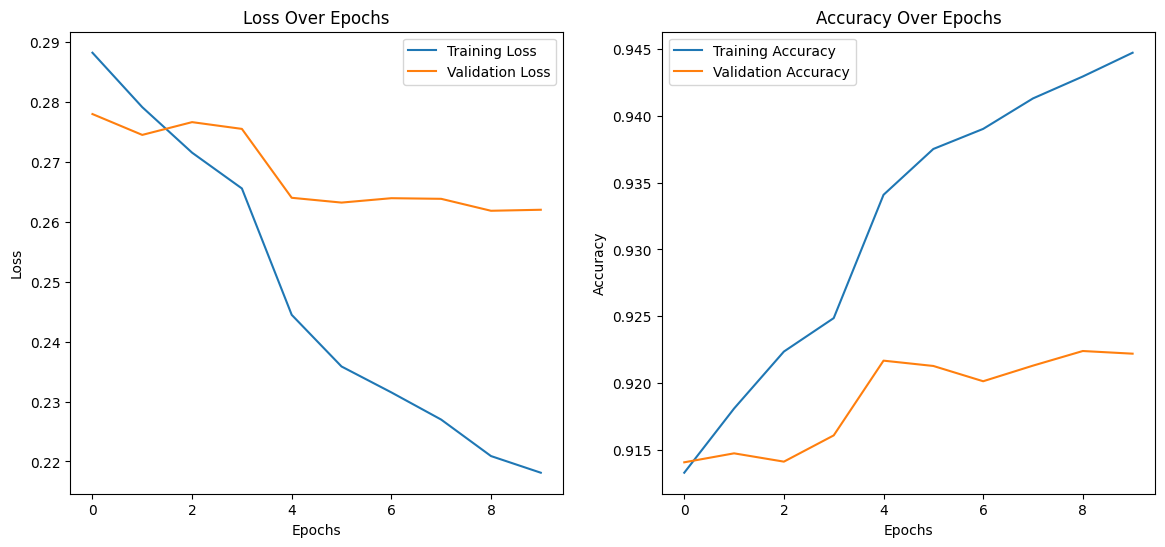

In [34]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Bidirection RNN

In [51]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, Reshape, BatchNormalization
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sentence_transformers import SentenceTransformer

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

# Data preprocessing
df = df.drop(columns=['Unnamed: 0', 'BinaryNumTarget'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()
df['majority_target'] = df['majority_target'].astype(int)

# Load pre-trained sentence transformer model and encode tweets
model_sbert = SentenceTransformer('all-MiniLM-L6-v2')
X_tweet_embeddings = model_sbert.encode(df['tweet'].tolist(), convert_to_numpy=True)

# Separate and scale numerical features
numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Split data into training and validation sets
X_train_tweet, X_val_tweet, X_train_num, X_val_num, y_train, y_val = train_test_split(
    X_tweet_embeddings, X_num_scaled, df['majority_target'], test_size=0.3, random_state=42)

# Define the model building function for Keras Tuner
def build_model(hp):
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dense_units = hp.Choice('dense_units', values=[32, 64])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    
    # Define inputs
    input_tweet = Input(shape=(X_tweet_embeddings.shape[1],))
    input_numerical = Input(shape=(X_num_scaled.shape[1],))

    # Reshape and LSTM layer for tweet embeddings
    reshaped_tweet = Reshape((1, X_tweet_embeddings.shape[1]))(input_tweet)
    lstm_tweet = Bidirectional(LSTM(lstm_units, return_sequences=False))(reshaped_tweet)
    lstm_tweet = BatchNormalization()(lstm_tweet)

    # Concatenate LSTM output with numerical features
    combined = Concatenate()([lstm_tweet, input_numerical])
    
    # Dense layers with dropout
    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001))(combined)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x) 
    x = Dense(dense_units // 2, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x) 
    output = Dense(1, activation='sigmoid')(x)

    # Compile model
    model = Model(inputs=[input_tweet, input_numerical], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Set to a small number to keep tuning time short
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='rnn_tuning'
)

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Start hyperparameter search
tuner.search([X_train_tweet, X_train_num], y_train, epochs=5, batch_size=32, validation_data=([X_val_tweet, X_val_num], y_val), callbacks=[early_stopping, reduce_lr])

# Retrieve the best model and hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Rebuild the model with the best hyperparameters
best_model = build_model(best_hp)

# Recompile the model to avoid the optimizer mismatch warning
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the best model further if desired
history = best_model.fit([X_train_tweet, X_train_num], y_train, epochs=10, batch_size=32, validation_data=([X_val_tweet, X_val_num], y_val), callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = best_model.evaluate([X_val_tweet, X_val_num], y_val)
print(f'Tuned Model Test Accuracy: {accuracy:.4f}')

# Predict on test data
y_pred = best_model.predict([X_val_tweet, X_val_num])
y_pred_use = (y_pred > 0.5).astype(int)

# Model evaluation metrics
accuracy = accuracy_score(y_val, y_pred_use)
print(f"Random Search RNN Accuracy: {accuracy:.4f}")
f1 = f1_score(y_val, y_pred_use, average='weighted')
print(f"Random Search RNN F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_use, target_names=['Fake', 'Real']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_use))

Reloading Tuner from tuning_dir\rnn_tuning\tuner0.json
Epoch 1/10


c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_78', 'keras_tensor_79']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2936/2936 ━━━━━━━━━━━━━━━━━━━━ 16s 4ms/step - accuracy: 0.7767 - loss: 0.5562 - val_accuracy: 0.8771 - val_loss: 0.3536 - learning_rate: 0.0010
Epoch 2/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8658 - loss: 0.3837 - val_accuracy: 0.8990 - val_loss: 0.3097 - learning_rate: 0.0010
Epoch 3/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8875 - loss: 0.3400 - val_accuracy: 0.9069 - val_loss: 0.2917 - learning_rate: 0.0010
Epoch 4/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8983 - loss: 0.3174 - val_accuracy: 0.9106 - val_loss: 0.2849 - learning_rate: 0.0010
Epoch 5/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9070 - loss: 0.3022 - val_accuracy: 0.9131 - val_loss: 0.2802 - learning_rate: 0.0010
Epoch 6/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9135 - loss: 0.2901 - val_accuracy: 0.9160 - val_loss: 0.2755 - learning_rate: 0.0010
Epoch 7/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.9175 - loss:

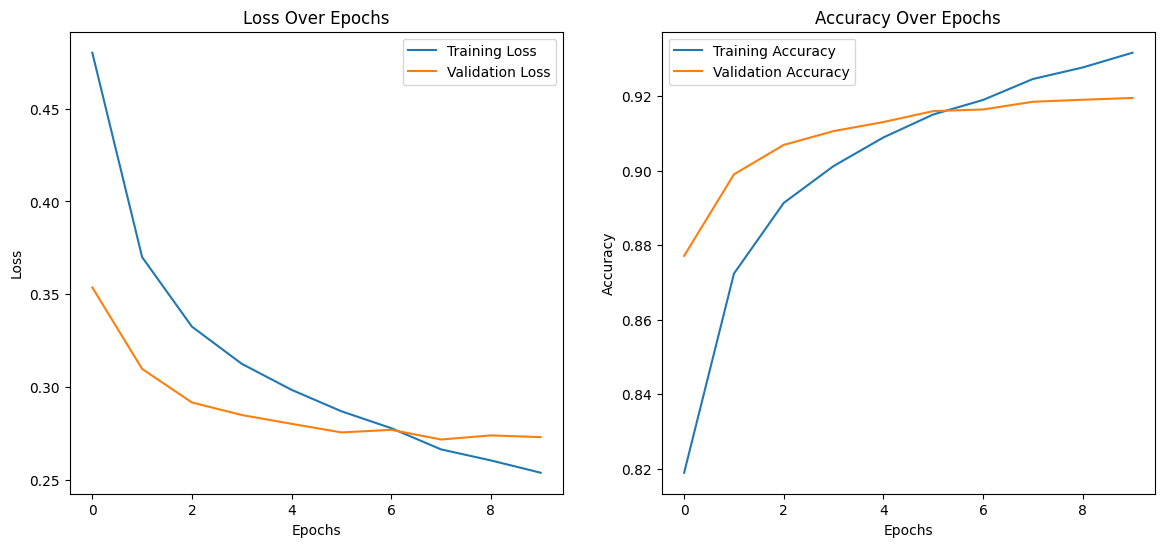

In [52]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

GloVe

In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import keras_tuner as kt
import gensim.downloader as api
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, BatchNormalization, Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

# Data preprocessing
df = df.drop(columns=['Unnamed: 0', 'BinaryNumTarget'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()
df['majority_target'] = df['majority_target'].astype(int)

# Load pre-trained GloVe model
word2vec_model = api.load("glove-wiki-gigaword-50")

# Tokenize and pad the sequences
max_words = 10000  # Maximum number of words to keep in the vocabulary
max_seq_length = 50  # Reduced maximum sequence length for padding

# Tokenizer to convert tweets to sequences of integers
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['tweet'])
sequences = tokenizer.texts_to_sequences(df['tweet'])

# Pad sequences to ensure equal length
X_padded = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

# Prepare the embedding matrix using GloVe
embedding_dim = 50  # GloVe model's dimensionality
word_index = tokenizer.word_index

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

# Populate the embedding matrix with GloVe vectors for words in the dataset
for word, i in word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
    else:
        # Randomly initialize words not found in GloVe model
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

# Separate and scale numerical features
numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Split data into training and validation sets
X_train_tweet, X_val_tweet, X_train_num, X_val_num, y_train, y_val = train_test_split(
    X_padded, X_num_scaled, df['majority_target'], test_size=0.3, random_state=42)

# Define the model building function for Keras Tuner
def build_model(hp):
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dense_units = hp.Choice('dense_units', values=[32, 64])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    
    # Define inputs
    input_tweet = Input(shape=(max_seq_length,))
    input_numerical = Input(shape=(X_num_scaled.shape[1],))

    # Embedding layer initialized with GloVe embedding matrix
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, 
                                weights=[embedding_matrix], input_length=max_seq_length, trainable=False)(input_tweet)

    # LSTM layer for tweet embeddings
    lstm_tweet = LSTM(lstm_units, return_sequences=False)(embedding_layer)
    lstm_tweet = BatchNormalization()(lstm_tweet)

    # Concatenate LSTM output with numerical features
    combined = Concatenate()([lstm_tweet, input_numerical])
    
    # Dense layers with dropout
    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001))(combined)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x) 
    x = Dense(dense_units // 2, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x) 
    output = Dense(1, activation='sigmoid')(x)

    # Compile model
    model = Model(inputs=[input_tweet, input_numerical], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Set to a small number to keep tuning time short
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='rnn_tuning'
)

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Start hyperparameter search
tuner.search([X_train_tweet, X_train_num], y_train, epochs=5, batch_size=32, validation_data=([X_val_tweet, X_val_num], y_val), callbacks=[early_stopping, reduce_lr])

# Retrieve the best model and hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Rebuild the model with the best hyperparameters
best_model = build_model(best_hp)

# Recompile the model to avoid the optimizer mismatch warning
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the best model further if desired
history = best_model.fit([X_train_tweet, X_train_num], y_train, epochs=10, batch_size=32, validation_data=([X_val_tweet, X_val_num], y_val), callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = best_model.evaluate([X_val_tweet, X_val_num], y_val)
print(f'Tuned Model Test Accuracy: {accuracy:.4f}')

# Predict on test data
y_pred = best_model.predict([X_val_tweet, X_val_num])
y_pred_use = (y_pred > 0.5).astype(int)

# Model evaluation metrics
accuracy = accuracy_score(y_val, y_pred_use)
print(f"Random Search RNN Accuracy: {accuracy:.4f}")
f1 = f1_score(y_val, y_pred_use, average='weighted')
print(f"Random Search RNN F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_use, target_names=['Fake', 'Real']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_use))

[==================================================] 100.0% 66.0/66.0MB downloaded
Reloading Tuner from tuning_dir\rnn_tuning\tuner0.json
Epoch 1/10


c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_26', 'keras_tensor_27']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2936/2936 ━━━━━━━━━━━━━━━━━━━━ 45s 15ms/step - accuracy: 0.6921 - loss: 0.6581 - val_accuracy: 0.8446 - val_loss: 0.4087 - learning_rate: 0.0010
Epoch 2/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 42s 14ms/step - accuracy: 0.8512 - loss: 0.3988 - val_accuracy: 0.8781 - val_loss: 0.3329 - learning_rate: 0.0010
Epoch 3/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 43s 14ms/step - accuracy: 0.8855 - loss: 0.3337 - val_accuracy: 0.8968 - val_loss: 0.2981 - learning_rate: 0.0010
Epoch 4/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 46s 16ms/step - accuracy: 0.9032 - loss: 0.3030 - val_accuracy: 0.8662 - val_loss: 0.3431 - learning_rate: 0.0010
Epoch 5/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 50s 17ms/step - accuracy: 0.9151 - loss: 0.2838 - val_accuracy: 0.9081 - val_loss: 0.2790 - learning_rate: 0.0010
Epoch 6/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 51s 17ms/step - accuracy: 0.9214 - loss: 0.2692 - val_accuracy: 0.8988 - val_loss: 0.2960 - learning_rate: 0.0010
Epoch 7/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 61s 21ms/step - accuracy: 0.9285 

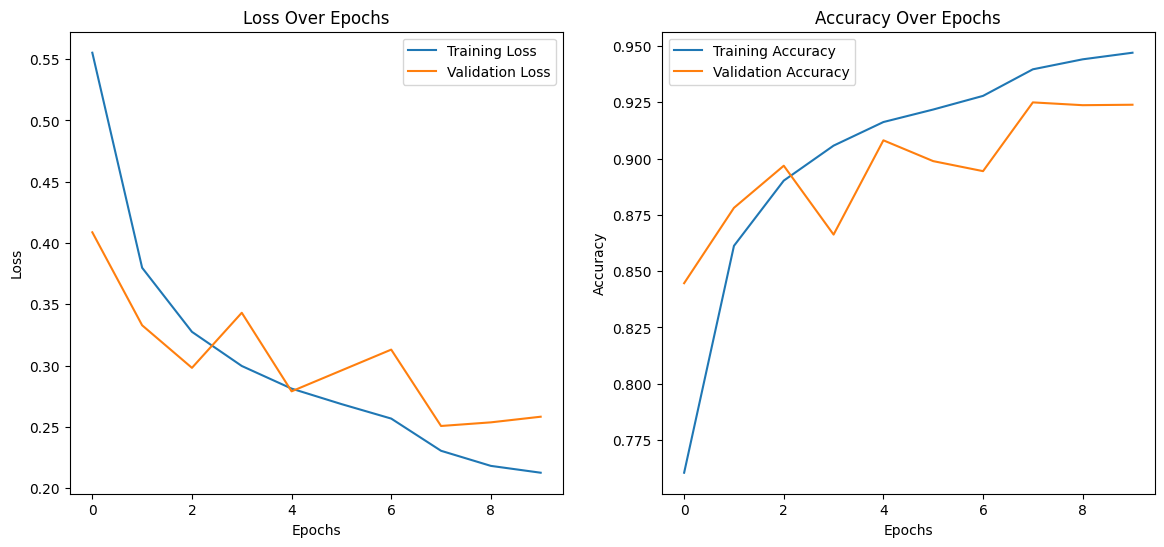

In [43]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

FastText

In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, BatchNormalization, Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from gensim.models.fasttext import FastText

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

# Data preprocessing
df = df.drop(columns=['Unnamed: 0', 'BinaryNumTarget'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()
df['majority_target'] = df['majority_target'].astype(int)

# Tokenizer
tweets = df['tweet'].tolist()
tokenizer = Tokenizer(num_words=5000)  # Limit the vocabulary to the 5000 most frequent words
tokenizer.fit_on_texts(tweets)
sequences = tokenizer.texts_to_sequences(tweets)
word_index = tokenizer.word_index  # Dictionary mapping words to their indices

# Pad sequences to ensure uniform input length
max_len = 100  # You can adjust this based on your dataset
X_padded = pad_sequences(sequences, maxlen=max_len)

# Train a FastText model on your dataset
# FastText learns subword information, making it robust for rare and unseen words
fasttext_model = FastText(sentences=[tweet.split() for tweet in tweets], vector_size=100, window=5, min_count=1, workers=4)

# Create the embedding matrix from FastText model
embedding_dim = 100  # FastText embedding dimension
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

for word, i in word_index.items():
    if word in fasttext_model.wv:
        embedding_matrix[i] = fasttext_model.wv[word]

# Separate and scale numerical features
numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Split data into training and validation sets
X_train_tweet, X_val_tweet, X_train_num, X_val_num, y_train, y_val = train_test_split(
    X_padded, X_num_scaled, df['majority_target'], test_size=0.3, random_state=42)

# Define the model building function for Keras Tuner
def build_model(hp):
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dense_units = hp.Choice('dense_units', values=[32, 64])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    
    # Define inputs
    input_tweet = Input(shape=(max_len,))
    input_numerical = Input(shape=(X_num_scaled.shape[1],))

    # Embedding layer with FastText embedding matrix
    embedding_layer = Embedding(input_dim=len(word_index) + 1, output_dim=embedding_dim, 
                                weights=[embedding_matrix], input_length=max_len, trainable=False)(input_tweet)
    
    # LSTM layer for tweet embeddings
    lstm_tweet = LSTM(lstm_units, return_sequences=False)(embedding_layer)
    lstm_tweet = BatchNormalization()(lstm_tweet)

    # Concatenate LSTM output with numerical features
    combined = Concatenate()([lstm_tweet, input_numerical])
    
    # Dense layers with dropout
    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001))(combined)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x) 
    x = Dense(dense_units // 2, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x) 
    output = Dense(1, activation='sigmoid')(x)

    # Compile model
    model = Model(inputs=[input_tweet, input_numerical], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Set to a small number to keep tuning time short
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='rnn_tuning'
)

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Start hyperparameter search
tuner.search([X_train_tweet, X_train_num], y_train, epochs=5, batch_size=32, validation_data=([X_val_tweet, X_val_num], y_val), callbacks=[early_stopping, reduce_lr])

# Retrieve the best model and hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Rebuild the model with the best hyperparameters
best_model = build_model(best_hp)

# Recompile the model to avoid the optimizer mismatch warning
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the best model further if desired
history = best_model.fit([X_train_tweet, X_train_num], y_train, epochs=10, batch_size=32, validation_data=([X_val_tweet, X_val_num], y_val), callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = best_model.evaluate([X_val_tweet, X_val_num], y_val)
print(f'Tuned Model Test Accuracy: {accuracy:.4f}')

# Predict on test data
y_pred = best_model.predict([X_val_tweet, X_val_num])
y_pred_use = (y_pred > 0.5).astype(int)

# Model evaluation metrics
accuracy = accuracy_score(y_val, y_pred_use)
print(f"Random Search RNN Accuracy: {accuracy:.4f}")
f1 = f1_score(y_val, y_pred_use, average='weighted')
print(f"Random Search RNN F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_use, target_names=['Fake', 'Real']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_use))


Reloading Tuner from tuning_dir\rnn_tuning\tuner0.json


c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10


c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_39', 'keras_tensor_40']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2936/2936 ━━━━━━━━━━━━━━━━━━━━ 131s 43ms/step - accuracy: 0.6841 - loss: 0.6621 - val_accuracy: 0.8403 - val_loss: 0.4129 - learning_rate: 0.0010
Epoch 2/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 138s 47ms/step - accuracy: 0.8443 - loss: 0.4165 - val_accuracy: 0.8805 - val_loss: 0.3362 - learning_rate: 0.0010
Epoch 3/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 119s 40ms/step - accuracy: 0.8725 - loss: 0.3608 - val_accuracy: 0.8885 - val_loss: 0.3194 - learning_rate: 0.0010
Epoch 4/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 151s 51ms/step - accuracy: 0.8874 - loss: 0.3330 - val_accuracy: 0.8812 - val_loss: 0.3287 - learning_rate: 0.0010
Epoch 5/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 149s 51ms/step - accuracy: 0.8968 - loss: 0.3153 - val_accuracy: 0.9036 - val_loss: 0.2929 - learning_rate: 0.0010
Epoch 6/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 119s 41ms/step - accuracy: 0.9039 - loss: 0.3025 - val_accuracy: 0.8973 - val_loss: 0.3029 - learning_rate: 0.0010
Epoch 7/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 86s 29ms/step - accuracy: 0

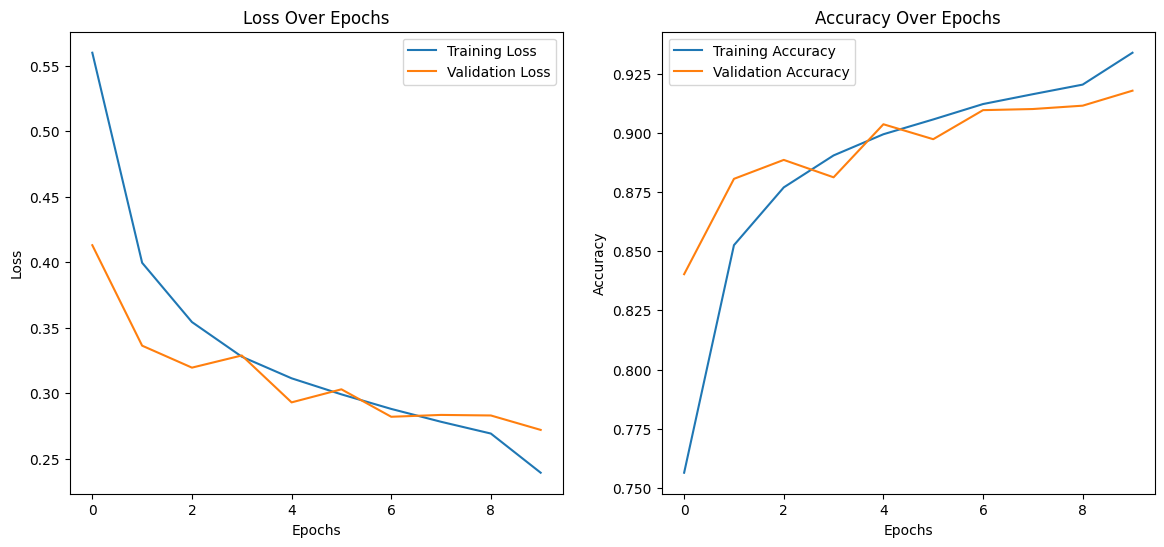

In [45]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

Word2Vec

In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import gensim.downloader as api
import keras_tuner as kt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Concatenate, BatchNormalization, Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Load dataset
with open("C:/Yee Ann/NUS/DSA4266/TruthSeeker2023/Features_For_Traditional_ML_Techniques.csv") as file:
    df = pd.read_csv(file)

# Data preprocessing
df = df.drop(columns=['Unnamed: 0', 'BinaryNumTarget'])
df = df.loc[:, df.nunique() > 1]
df = df.drop_duplicates()
df['majority_target'] = df['majority_target'].astype(int)

# Step 1: Load pre-trained Word2Vec model (from Gensim API)
word2vec_model = api.load("word2vec-google-news-300")  # Automatically downloads 300-dimensional vectors

# Step 3: Tokenize and pad the sequences
max_words = 10000  # Maximum number of words to keep in the vocabulary
max_seq_length = 50  # Maximum sequence length for padding

# Tokenizer to convert tweets to sequences of integers
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['tweet'])
sequences = tokenizer.texts_to_sequences(df['tweet'])

# Pad sequences to ensure equal length
X_padded = pad_sequences(sequences, maxlen=max_seq_length, padding='post', truncating='post')

# Step 4: Prepare the embedding matrix using Word2Vec
embedding_dim = 300  # Word2Vec model's dimensionality
word_index = tokenizer.word_index

# Initialize the embedding matrix with zeros
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))

# Populate the embedding matrix with Word2Vec vectors for words in the dataset
for word, i in word_index.items():
    if word in word2vec_model:
        embedding_matrix[i] = word2vec_model[word]
    else:
        # Randomly initialize words not found in Word2Vec model
        embedding_matrix[i] = np.random.normal(size=(embedding_dim,))

# Separate and scale numerical features
numerical_features = df.select_dtypes(['int64', 'int32', 'float64']).columns.tolist()
numerical_features.remove('majority_target')
X_num = df[numerical_features].values
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

# Split data into training and validation sets
X_train_padded, X_val_padded, X_train_num, X_val_num, y_train, y_val = train_test_split(
    X_padded, X_num_scaled, df['majority_target'], test_size=0.3, random_state=42)

# Define the model building function for Keras Tuner
def build_model(hp):
    lstm_units = hp.Int('lstm_units', min_value=32, max_value=128, step=32)
    dense_units = hp.Choice('dense_units', values=[32, 64])
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    
    # Define inputs
    input_tweet = Input(shape=(X_padded.shape[1],))  # Use padded sequences as input
    input_numerical = Input(shape=(X_num_scaled.shape[1],))

    # Embedding layer with Word2Vec embedding matrix
    embedding_layer = Embedding(input_dim=embedding_matrix.shape[0], output_dim=embedding_dim, 
                                weights=[embedding_matrix], input_length=X_padded.shape[1], trainable=False)(input_tweet)
    
    # LSTM layer for tweet embeddings
    lstm_tweet = LSTM(lstm_units, return_sequences=False)(embedding_layer)
    lstm_tweet = BatchNormalization()(lstm_tweet)

    # Concatenate LSTM output with numerical features
    combined = Concatenate()([lstm_tweet, input_numerical])
    
    # Dense layers with dropout
    x = Dense(dense_units, activation='relu', kernel_regularizer=l2(0.001))(combined)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x) 
    x = Dense(dense_units // 2, activation='relu', kernel_regularizer=l2(0.001))(x)
    x = Dropout(dropout_rate)(x)
    x = BatchNormalization()(x) 
    output = Dense(1, activation='sigmoid')(x)

    # Compile model
    model = Model(inputs=[input_tweet, input_numerical], outputs=output)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Initialize Keras Tuner with RandomSearch
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Set to a small number to keep tuning time short
    executions_per_trial=1,
    directory='tuning_dir',
    project_name='rnn_tuning'
)

# Callbacks for training
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Start hyperparameter search
tuner.search([X_train_padded, X_train_num], y_train, epochs=5, batch_size=32, validation_data=([X_val_padded, X_val_num], y_val), callbacks=[early_stopping, reduce_lr])

# Retrieve the best model and hyperparameters
best_hp = tuner.get_best_hyperparameters()[0]

# Rebuild the model with the best hyperparameters
best_model = build_model(best_hp)

# Recompile the model to avoid the optimizer mismatch warning
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the best model further if desired
history = best_model.fit([X_train_padded, X_train_num], y_train, epochs=10, batch_size=32, validation_data=([X_val_padded, X_val_num], y_val), callbacks=[early_stopping, reduce_lr])

# Evaluate the model
loss, accuracy = best_model.evaluate([X_val_padded, X_val_num], y_val)
print(f'Tuned Model Test Accuracy: {accuracy:.4f}')

# Predict on test data
y_pred = best_model.predict([X_val_padded, X_val_num])
y_pred_use = (y_pred > 0.5).astype(int)

# Model evaluation metrics
accuracy = accuracy_score(y_val, y_pred_use)
print(f"Random Search RNN Accuracy: {accuracy:.4f}")
f1 = f1_score(y_val, y_pred_use, average='weighted')
print(f"Random Search RNN F1 Score: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_val, y_pred_use, target_names=['Fake', 'Real']))
print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred_use))

Reloading Tuner from tuning_dir\rnn_tuning\tuner0.json


c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10


c:\Users\laiye\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_65', 'keras_tensor_66']. Received: the structure of inputs=('*', '*')
  warnings.warn(


2936/2936 ━━━━━━━━━━━━━━━━━━━━ 61s 19ms/step - accuracy: 0.6949 - loss: 0.6437 - val_accuracy: 0.8593 - val_loss: 0.3778 - learning_rate: 0.0010
Epoch 2/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - accuracy: 0.8602 - loss: 0.3837 - val_accuracy: 0.8480 - val_loss: 0.3730 - learning_rate: 0.0010
Epoch 3/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 55s 19ms/step - accuracy: 0.8950 - loss: 0.3173 - val_accuracy: 0.8878 - val_loss: 0.3069 - learning_rate: 0.0010
Epoch 4/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 55s 19ms/step - accuracy: 0.9136 - loss: 0.2817 - val_accuracy: 0.8975 - val_loss: 0.2973 - learning_rate: 0.0010
Epoch 5/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 66s 22ms/step - accuracy: 0.9246 - loss: 0.2632 - val_accuracy: 0.9175 - val_loss: 0.2631 - learning_rate: 0.0010
Epoch 6/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 72s 24ms/step - accuracy: 0.9321 - loss: 0.2465 - val_accuracy: 0.9099 - val_loss: 0.2877 - learning_rate: 0.0010
Epoch 7/10
2936/2936 ━━━━━━━━━━━━━━━━━━━━ 65s 22ms/step - accuracy: 0.9379 

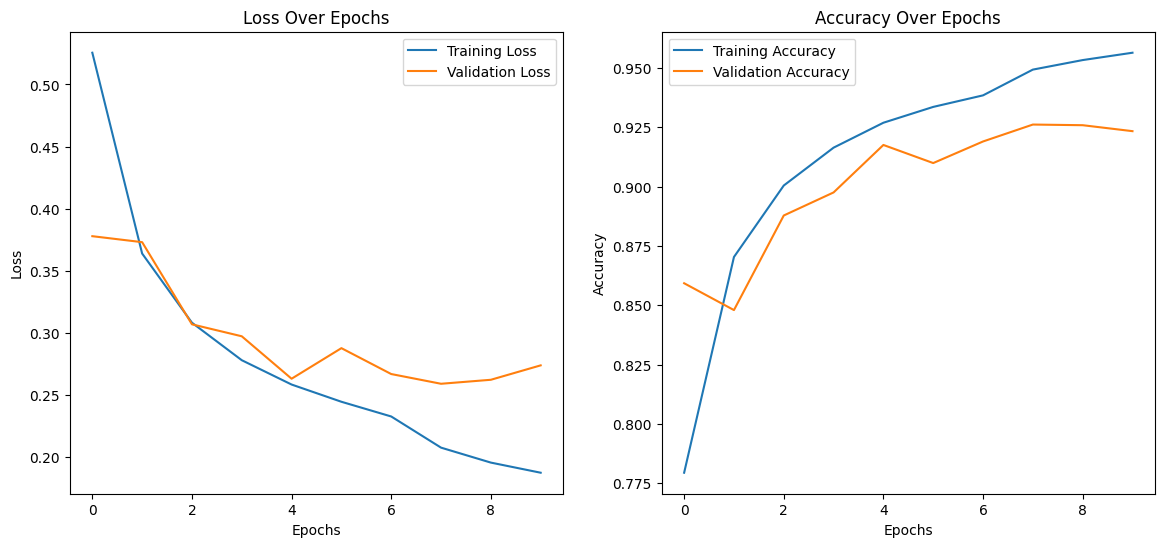

In [ ]:
import matplotlib.pyplot as plt

# Plotting training & validation loss
plt.figure(figsize=(14, 6))

# Loss Plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()